<a href="https://colab.research.google.com/github/okana2ki/ML/blob/main/CNN2answer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 最初にやること
1. ログインがまだの場合、（大学のメールアドレスではなく）**個人のGoogleアカウントでログイン**。大学のメールアドレスでログインしている場合は、個人のGoogleアカウントに切り替え。←**Colab内でGemini（生成AI）を使うために必要**
2. ↑上部の「**ドライブにコピー**」をクリックし、ノートブックを自分のドライブにコピー。←書き込んだ内容や実行結果を保存するために必要

# 畳込みニューラルネットワーク

---



このノートブックは、https://www.stat.go.jp/teacher/comp-learn-04.html に掲載された[ノートブック](https://www.stat.go.jp/teacher/dl/python/c4learn/materials/fourth/NeuralNet.ipynb)を元に加筆・改変したものです。

この演習では深層学習の1つである畳込みニューラルネットワークの学習を実行するので、以下の操作により**GPUが使えるように設定**しておきましょう。\
画面左上部の「ランタイム」をクリック→「ランタイムのタイプを変更」をクリック→「T4 GPU」を選択し「保存」をクリック\
無料プランの場合、GPUを使える時間等の制限が強いため、演習問題を解くために実行を続けていると、しばらくの間GPUが使えなくなることが起こりえます。その場合でも、CPUだけでも遅いが実行可能な小さめのニューラルネットにしてあるので、何とかなると思います。


## データの準備
[ここ](https://drive.google.com/drive/folders/1h-4DERuXq6p8l8OR0BcbH0K58cPUdlEP?usp=sharing)をクリック→画面最上部の「image_data▼」をクリック→プルダウンメニューの「ダウンロード」をクリック→圧縮ファイルとしてダウンロードされるので、それを右クリック→プルダウンメニューから「すべて展開...」をクリック→展開されたimage_dataフォルダを自分のGoogle Driveの適当な場所に（ドラッグアンドドロップなどの方法で）フォルダごとアップロード

### 演習問題１
アップロードしたimage_dataフォルダの下には、5つ（2024/6/3時点）の国別フォルダがあり、各フォルダには、それぞれの国の[世界遺産の写真](https://whc.unesco.org/ja/list/)が格納されています。

以下では、写真を見て国名を答える問題をニューラルネットに学習させるのですが、ここでは、まず、次の1.と2.の確認をして下さい。
1. 学習対象として不適切な写真（不鮮明など）や、分類の誤り（正しい国名のフォルダに写真が存在しない）や、写真の重複などがないことを確認して下さい。
2. **皆さんが自分で写真を見て、AIや自分が写真から国名を答えられそうかを一通り見ておいて下さい**。より具体的な問題として書くと、写真のうち8割を使って学習した場合、残りの2割の学習時に見なかった写真の国名を答えられるか、という問題です。

データ分析の第一歩は、データに不備がないか確認すること（上記の1.）で、次に、データを可視化してその特徴をつかむこと（上記の2.）です。今回は写真データなので、可視化は初めからできているのですが、目視で、**学習可能性について当たりをつける**のは、基本的で必須の作業で、学習システムを作る際に、最初にやるべきことです。

演習問題１の回答（あなたの見解）をここに書いて下さい\



## グーグルドライブのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## ライブラリのインポート

In [ ]:
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## データの読み込み

Google Driveをマウントし、そこから読み込む。

In [ ]:
# データパスの設定：下記はGoogle DriveのColab_filesフォルダの下にimage_dataフォルダを置いた場合
# 置いた場所に応じて適宜書き換えて下さい【必須】
data_path = '/content/drive/MyDrive/Colab_files/image_data'

# 各ディレクトリの画像に与えるラベル
# Vatican_Cityは写真が1枚だけなので、今回はデータとしては読み込まない
# labelは、0, 1, 2, 3のいずれか；通常、このように、何番目のクラスかを表すインデックスをラベルにする
label_dict = {"USA": 0, "Italy": 1, "Australia": 2, "Austria": 3}

# 学習用のデータ（画像のリストと、ラベルのリスト）を作る。最初は空リストに初期化。
image_list = []
label_list = []

for dir in os.listdir(data_path):
    dataset_path = os.path.join(data_path, dir)
    label = label_dict.get(dir, -1)

    if label != -1:
        for file in os.listdir(dataset_path):
            label_list.append(label)  # label_listに正解ラベルを追加
            filepath = os.path.join(dataset_path, file)
            print(filepath)
            image = Image.open(filepath)
            image = image.resize((500, 500), Image.BICUBIC)  # Bicubic補間で500x500ピクセルに変換
            image = np.asarray(image)
            image_list.append(image / 255.)  # ピクセル値を0から1の範囲に正規化してimage_listに画像を追加
    else:
        print(f"Skipping directory: {dir} (unknown label)")

# kerasに渡すためにnumpy配列に変換。
X = np.array(image_list)
Y = np.array(label_list)

/content/drive/MyDrive/Colab_files/image_data/Austria/オーストリアーハルシュタット.jpg
/content/drive/MyDrive/Colab_files/image_data/Austria/オーストリアーウィーン歴史地区.jpg
/content/drive/MyDrive/Colab_files/image_data/Austria/オーストリアーシェーンブルン宮殿.jpg
/content/drive/MyDrive/Colab_files/image_data/Australia/オーストラリアーフリーマントル刑務所.jpg
/content/drive/MyDrive/Colab_files/image_data/Australia/オーストラリアーキュランダ.jpg
/content/drive/MyDrive/Colab_files/image_data/Australia/オーストラリアー王立展示館とカールトン庭園.jpg
/content/drive/MyDrive/Colab_files/image_data/Australia/オーストラリアーブルーマウンテンズ.jpg
/content/drive/MyDrive/Colab_files/image_data/Australia/オーストラリアーポートアーサー.jpg
/content/drive/MyDrive/Colab_files/image_data/Australia/オーストラリアーグレートバリアリーフ.jpg
/content/drive/MyDrive/Colab_files/image_data/Australia/オーストラリア-カカドゥ国立公園.jpg
/content/drive/MyDrive/Colab_files/image_data/Australia/オーストラリアーオペラハウス.jpg
/content/drive/MyDrive/Colab_files/image_data/Italy/イタリアーコロッセオ.jpg
/content/drive/MyDrive/Colab_files/image_data/Italy/イタリアーアマルフィ海岸.jpg
/content/driv

Google Driveを使わずColab内にフォルダ（ディレクトリ）を作ってそこにデータを置く場合は、下記を実行後、全写真ファイルをドラッグアンドドロップ（フォルダのアップロードはできない）。ランタイムの接続が切れるたびに、データをアップロードし直さないといけないので推奨はしないが、Google Driveが使えないときはこの方法で。

In [ ]:
# Google Driveからデータを読み込む場合は、このセルは実行しなくてよい
import os
# Colab内にディレクトリを作成

#ラベルUSAのディレクトリを作成
DIR = "image_data/USA"
# DIRの名称のディレクトリがなければ作成
if not os.path.exists(DIR):
    os.makedirs(DIR)

#ラベルItalyのディレクトリを作成
DIR = "image_data/Italy"
# DIRの名称のディレクトリがなければ作成
if not os.path.exists(DIR):
    os.makedirs(DIR)

#ラベルAustraliaのディレクトリを作成
DIR = "image_data/Australia"
# DIRの名称のディレクトリがなければ作成
if not os.path.exists(DIR):
    os.makedirs(DIR)

#ラベルAustriaのディレクトリを作成
DIR = "image_data/Austria"
# DIRの名称のディレクトリがなければ作成
if not os.path.exists(DIR):
    os.makedirs(DIR)

画像の1つを確認のために表示します。

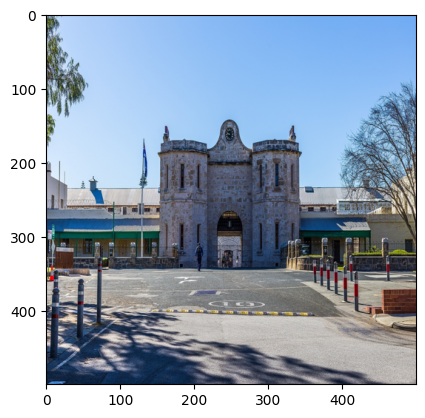

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.imshow(X[3])

In [ ]:
X.shape  # image

(35, 500, 500, 3)

In [ ]:
print(X[3])  # 画像データの中の1枚がどのように表現されているか確認

[[[0.50980392 0.54901961 0.55686275]
  [0.43921569 0.49019608 0.53333333]
  [0.49019608 0.5254902  0.64313725]
  ...
  [0.44313725 0.6627451  0.95294118]
  [0.43921569 0.65882353 0.94901961]
  [0.45098039 0.66666667 0.95294118]]

 [[0.3254902  0.38823529 0.38823529]
  [0.24705882 0.29803922 0.36862745]
  [0.45490196 0.49411765 0.60784314]
  ...
  [0.43921569 0.65882353 0.94901961]
  [0.44705882 0.66666667 0.95686275]
  [0.45098039 0.66666667 0.95294118]]

 [[0.45490196 0.54117647 0.61960784]
  [0.43529412 0.51372549 0.64313725]
  [0.50196078 0.56470588 0.69019608]
  ...
  [0.44313725 0.6627451  0.95294118]
  [0.44705882 0.66666667 0.95686275]
  [0.44705882 0.6627451  0.95294118]]

 ...

 [[0.08235294 0.1372549  0.22352941]
  [0.10196078 0.18039216 0.25882353]
  [0.06666667 0.14901961 0.23137255]
  ...
  [0.6627451  0.63921569 0.63529412]
  [0.57647059 0.55294118 0.56078431]
  [0.59607843 0.57254902 0.58039216]]

 [[0.05882353 0.11764706 0.18431373]
  [0.12156863 0.16862745 0.24313725]


In [ ]:
Y.shape  # label

(35,)

In [ ]:
print(Y)

[3 3 3 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]


## 訓練データとテストデータに分割

In [ ]:
# （8:2）データを訓練データとテストデータにランダム分割
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)  # 分割に再現性が必要な場合：ランダムシードを指定

In [ ]:
print(Y_test)

[2 2 1 0 1 1 1]


## モデルの作成
`tf.keras.layers.Conv2D(16, (3, 3), input_shape=(500, 500, 3), activation="relu")`\
16個のフィルター（特徴マップ）を持つ畳み込み層を定義しています。
各フィルターは3x3のサイズです。
入力画像は500x500ピクセルのカラー画像（3チャンネル）を想定しています。
活性化関数にはReLU関数を指定しています。

`tf.keras.layers.MaxPool2D((2, 2))`\
2x2の最大プーリング層を定義しています。これは、画像の解像度を下げ、重要な特徴を抽出するのに役立ちます。

In [ ]:
model = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(16, (3, 3),
                                                    input_shape=(500, 500, 3), activation="relu"),
                             tf.keras.layers.MaxPool2D((2, 2)),
                             tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
                             tf.keras.layers.MaxPool2D((2, 2)),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(16),
                             tf.keras.layers.Dense(4, activation="softmax")
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 249, 249, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 123, 123, 32)      0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 484128)            0         
                                                                 
 dense (Dense)               (None, 16)                7

In [ ]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy", metrics=["accuracy"])

## 訓練データで学習

In [ ]:
# np.random.seed(1)  # 再現性必要ならシードをセット
# tf.random.set_seed(2)  # 再現性必要ならシードをセット
model.fit(X_train, Y_train, epochs=20)

Epoch 1/20
1/1 [==============================] - 6s 6s/step - loss: 1.3516 - accuracy: 0.3571
Epoch 2/20
1/1 [==============================] - 6s 6s/step - loss: 124.9733 - accuracy: 0.5357
Epoch 3/20
1/1 [==============================] - 5s 5s/step - loss: 74.1764 - accuracy: 0.5357
Epoch 4/20
1/1 [==============================] - 5s 5s/step - loss: 35.8390 - accuracy: 0.2143
Epoch 5/20
1/1 [==============================] - 6s 6s/step - loss: 18.4599 - accuracy: 0.3214
Epoch 6/20
1/1 [==============================] - 4s 4s/step - loss: 12.9826 - accuracy: 0.2143
Epoch 7/20
1/1 [==============================] - 5s 5s/step - loss: 12.8030 - accuracy: 0.5357
Epoch 8/20
1/1 [==============================] - 6s 6s/step - loss: 13.0377 - accuracy: 0.6786
Epoch 9/20
1/1 [==============================] - 4s 4s/step - loss: 16.1413 - accuracy: 0.5357
Epoch 10/20
1/1 [==============================] - 6s 6s/step - loss: 14.4658 - accuracy: 0.5714
Epoch 11/20
1/1 [======================

In [ ]:
# 学習したモデルをファイルに保存 ← 保存が必要な場合のみ実行
# 保存したいディレクトリに応じて下記を書き換えること。下記はマイドライブの下にColab_filesというディレクトリが存在することを前提。
model.save('/content/drive/MyDrive/Colab_files/my_model.keras')

In [ ]:
# 保存したファイルの読み込み ← 保存したファイルを読み込む場合だけ実行
# 保存したディレクトリとファイル名に応じて下記を書き換えること。
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab_files/my_model.keras')

## テストデータで精度評価

In [ ]:
# 損失と正解率を表示
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Loss: {}, Accuracy: {}'.format(loss, accuracy))

Loss: 3.615846872329712, Accuracy: 0.2857142984867096


1/1 [==============================] - 0s 468ms/step


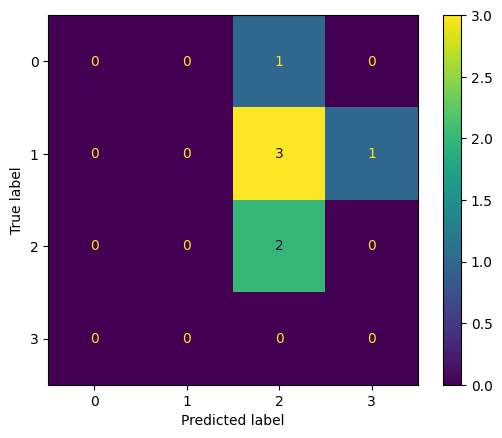

In [ ]:
# 予測値を取得
Y_pred = model.predict(X_test)

# 混同行列を表示
cm = confusion_matrix(Y_test, Y_pred.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### 演習問題２
テストセットの各画像を表示し、それぞれの画像に対する正解ラベルと予測結果を合わせて表示するプログラムを書きなさい。

In [ ]:
# prompt: テストセットの各画像を表示し、それぞれの画像に対する正解ラベルと予測結果を合わせて表示するプログラムを書きなさい。

import matplotlib.pyplot as plt

# テストセットの各画像をループで処理
for i in range(len(X_test)):
  # 画像を表示
  plt.imshow(X_test[i])
  plt.show()

  # 正解ラベルと予測結果を取得
  true_label = Y_test[i]
  predicted_label = Y_pred[i].argmax()

  # 正解ラベルと予測結果を表示
  print(f"正解ラベル: {true_label}, 予測結果: {predicted_label}")

1/1 [==============================] - 0s 387ms/step


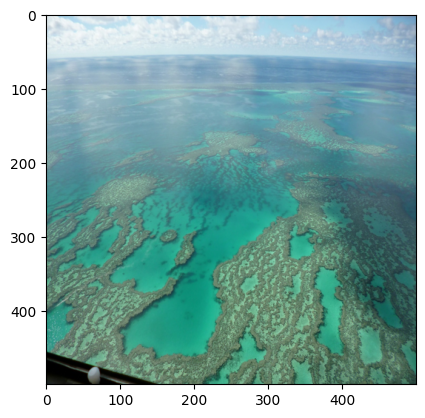

正解ラベル: Australia
予測結果: Australia
USA: 0.19%
Italy: 0.06%
Australia: 99.63%
Austria: 0.12%


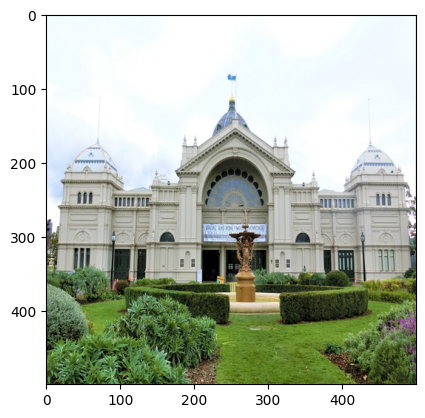

正解ラベル: Australia
予測結果: Australia
USA: 0.00%
Italy: 0.30%
Australia: 99.70%
Austria: 0.00%


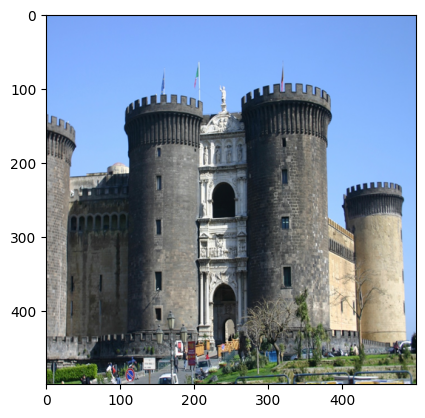

正解ラベル: Italy
予測結果: Australia
USA: 0.01%
Italy: 29.73%
Australia: 53.83%
Austria: 16.43%


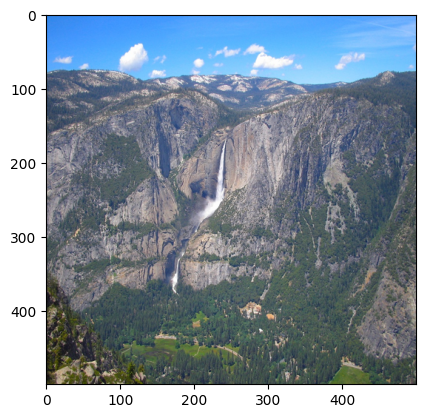

正解ラベル: USA
予測結果: Australia
USA: 0.01%
Italy: 5.19%
Australia: 87.64%
Austria: 7.16%


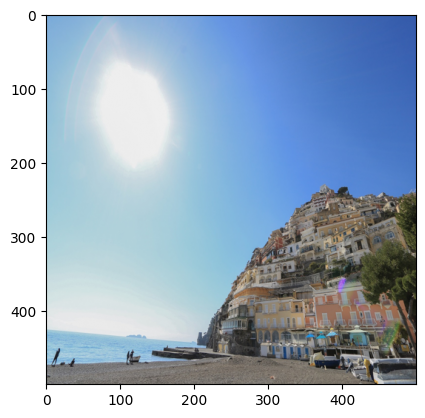

正解ラベル: Italy
予測結果: Australia
USA: 0.03%
Italy: 0.11%
Australia: 95.53%
Austria: 4.33%


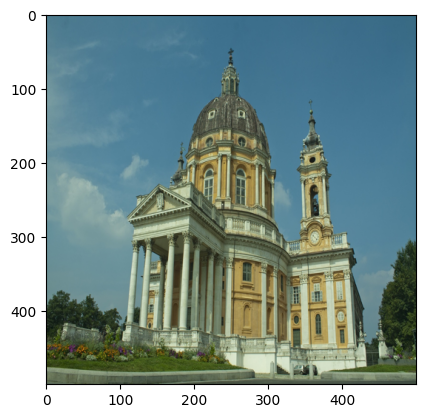

正解ラベル: Italy
予測結果: Austria
USA: 0.01%
Italy: 27.00%
Australia: 22.50%
Austria: 50.49%


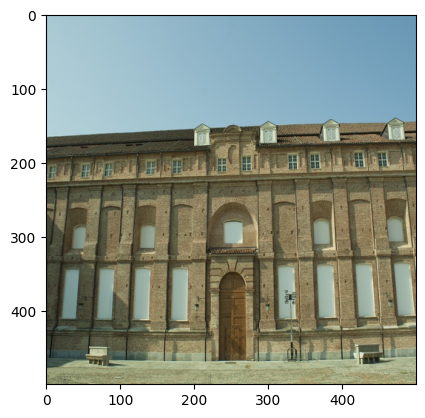

正解ラベル: Italy
予測結果: Australia
USA: 0.00%
Italy: 0.21%
Australia: 99.79%
Austria: 0.00%


In [ ]:
# ラベル名を取得する準備
label_dict = {"USA": 0, "Italy": 1, "Australia": 2, "Austria": 3}
label_names = list(label_dict.keys())

# 予測値を取得
Y_pred = model.predict(X_test)

# テストセットの各画像を表示し、それぞれの画像に対する正解ラベルと予測結果を合わせて表示
for i in range(len(X_test)):
    plt.imshow(X_test[i])
    plt.show()

    print(f"正解ラベル: {label_names[Y_test[i]]}")
    print(f"予測結果: {label_names[Y_pred.argmax(axis=1)[i]]}")
    for i, element in enumerate(Y_pred[i]):
        percentage = element * 100
        percentage_string = f"{percentage:.2f}%"
        label = label_names[i]
        print(f"{label}: {percentage_string}")

### 演習問題３
正しくラベルを予測できた画像とそうでない画像には、どのような傾向がありましたか？訓練セットとテストセットの分割の仕方を変えてみたり（ランダムに分割するので結果は毎回変わる）、学習をやり直してみたり（学習にはランダム性があるので結果は毎回変わる）して、いろいろなケースを試すことにより、傾向をつかんで下さい。

### 演習問題４
データセットが小さいため、正解率などの評価が毎回大きく変わることに気づいたと思う。このような場合は、ホールドアウトを1回実行するだけでは信頼できる評価結果は得られないため、交差検証（クロスバリデーション）を行うべきだと考えられる。交差検証を行うプログラムを書いて実行しなさい。\
もし、学習をやり直すたびに評価結果が大きく異なる場合は、何回か学習し直し、それぞれの回の評価結果の平均を最終的な結果として報告するのがよいと思われる。この方法をとる必要があると判断した場合は、そのためのプログラムを書いて実行しなさい。

### 演習問題５
データセットが小さいため精度向上は難しいという結論になったとすると、データセットを大きくしてどれくらい精度が向上するか試してみる価値があります。[世界遺産のサイト](https://whc.unesco.org/ja/list/)には、写真も掲載されているので、みんなで手分けしてデータセットを大きくしてみるのは興味深い試みだと思います。以下を適宜分担して実行してみましょう。
1. すでにデータがある国の写真を増やしてみる
2. 新しい国のデータを集めてみる

# 以下は未修正の参考プログラム
以下のプログラムはこのままでは動きません。演習問題の参考になるかもしれないので残しておきます。

### 実行結果

In [ ]:
label_names = ["USA","Italy","Australia"]

correct_data = test_data[pred == test_label]
correct_label = pred[pred == test_label]
count_correct=len(correct_label)
print(count_correct)

2


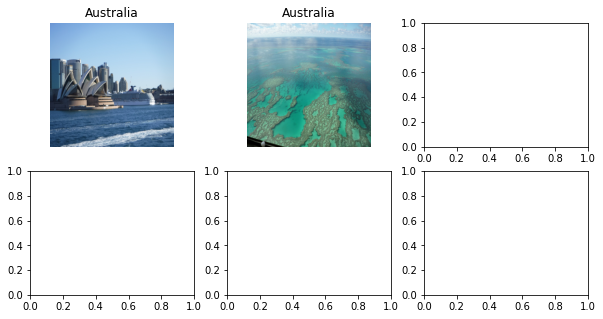

In [ ]:
#正解した画像を表示
flg, axes = plt.subplots(2, 3, figsize=(10, 5))

for i in range(count_correct):
  ax = axes[i // 3][i % 3]
  ax.set_title(label_names[correct_label[i]])
  ax.axis("off")
  ax.imshow(correct_data[i])

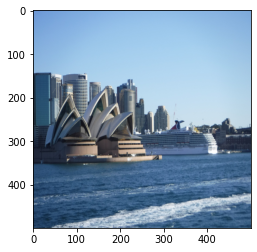

In [ ]:
plt.imshow(correct_data[0])

# 以下は、参考情報：生成AIとのやりとりをメモとして残しておく
プログラムとして採用しなかったが、クラス名をCNNの出力にする方法（標準的でない）

In [ ]:
# データパスの設定：下記はGoogle DriveのColab_filesフォルダの下にimage_dataフォルダを置いた場合
# 置いた場所に応じて適宜書き換えて下さい【必須】
data_path = '/content/drive/MyDrive/Colab_files/image_data'

# 各ディレクトリの画像に与えるラベル
# Vatican_Cityは写真が1枚だけなので、今回はデータとしては読み込まない
label_dict = {"USA": 0, "Italy": 1, "Australia": 2, "Austria": 3}

# 学習用のデータ（画像のリストと、ラベルのリスト）を作る。最初は空リストに初期化。
image_list = []
label_list = []

for dir in os.listdir(data_path):
    dataset_path = os.path.join(data_path, dir)
    label = dir

    if label == "USA" or label == "Italy" or label == "Australia" or label == "Austria":
        for file in os.listdir(dataset_path):
            label_list.append(label)  # label_listに正解ラベルを追加
            filepath = os.path.join(dataset_path, file)
            print(filepath)
            image = Image.open(filepath)
            image = image.resize((500, 500), Image.BICUBIC)  # Bicubic補間で500x500ピクセルに変換
            image = np.asarray(image)
            image_list.append(image / 255.)  # ピクセル値を0から1の範囲に正規化してimage_listに画像を追加
    else:
        print(f"Skipping directory: {dir} (unknown label)")

# kerasに渡すためにnumpy配列に変換。
X = np.array(image_list)
Y = np.array(label_list)

あなた モデルへの入力は文字列は含みません。モデルの出力が文字列です。

Gemini I apologize for my previous response, which was incorrect.

Since the model output is strings, you need to change the activation function of the last layer to tf.keras.activations.serialize. This activation function converts the output of the model to strings.

Here's the modified code:

model = tf.keras.Sequential([ tf.keras.layers.Conv2D(16, (3, 3), input_shape=(500, 500, 3), activation="relu"), tf.keras.layers.MaxPool2D((2, 2)), tf.keras.layers.Conv2D(32, (3, 3), activation="relu"), tf.keras.layers.MaxPool2D((2, 2)), tf.keras.layers.Flatten(), tf.keras.layers.Dense(16), tf.keras.layers.Dense(4, activation=tf.keras.activations.serialize) ]) Use code with caution This should fix the error and allow the model to output strings.

ソース yoshisatoh/ML stackoverflow.com/questions/62245075/model-accuracy-not-increasing-while-using-tensorflow-datasets

あなた 元は出力が0,1,2,3のどれかだったのを、4種類の文字列に変更したいのですが、先ほどの変更で合っていますか？

Gemini Yes, the change I suggested in my previous response should allow you to change the output of the model from integers (0, 1, 2, 3) to strings.

Here's how it works:

The tf.keras.activations.serialize activation function converts the output of the model to strings. By default, the serialize activation function uses the names of the classes as the strings. In your case, you have 4 classes, so the model will output one of the following strings: "0", "1", "2", or "3". If you want to use different strings, you can pass a list of strings to the serialize activation function. For example, the following code would make the model output the strings "apple", "banana", "cherry", and "mango":

model = tf.keras.Sequential([ # ... same as before ... tf.keras.layers.Dense(4, activation=tf.keras.activations.serialize(["apple", "banana", "cherry", "mango"])) ]) Use code with caution I hope this helps!